# Hands-On Image Workshop: *Detecting Defects in Steel Strips Using Computer Vision* 

Within this hands-on workshop you will use a two different convolutional neural networks (CNNs) to classify different types of defects commonly found in steel strips. 

(And, if you're anything like the author you'll what on Earth defects in steel strips even look like!)

The steps which you will carry out are: 
1. Load the data
2. Perform some data exploration and visualisation
3. Build a couple of different CNNs and deploy these to Seldon
4. Add metadata to your newly created models
5. Create a drift detector and once again create this on Seldon

The model training code has been adapted from this blog post by `franky` on Medium: [Deep Learning, Computer Vision, and Automated Optical Inspection](https://towardsdatascience.com/deep-learning-computer-vision-and-automated-optical-inspection-774e8ca529d3)

Firstly, we will install and import the relevant packages which we will use throughout the exploration, training, and deployment process. Google Colab comes with a number of packages pre-installed, so we only need to install any additional packages we may need.

In [1]:
!pip install seldon_deploy_sdk
!pip install alibi-detect==0.8.1
!pip install dill
!pip install tensorflow

  Using cached alibi_detect-0.8.1-py3-none-any.whl (311 kB)
ERROR: Could not find a version that satisfies the requirement tensorflow!=2.6.0,!=2.6.1,<2.8.0,>=2.2.0 (from alibi-detect) (from versions: 2.13.0rc0, 2.13.0rc1)
ERROR: No matching distribution found for tensorflow!=2.6.0,!=2.6.1,<2.8.0,>=2.2.0
  Using cached tensorflow_macos-2.13.0rc1-cp39-cp39-macosx_12_0_arm64.whl (189.3 MB)
  Using cached keras-2.13.1rc0-py3-none-any.whl (1.7 MB)
  Using cached tensorflow_estimator-2.13.0rc0-py2.py3-none-any.whl (440 kB)
  Using cached tensorboard-2.13.0-py3-none-any.whl (5.6 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing 

In [1]:
# General Packages
import os
import logging
import json
import numpy as np
import dill
import matplotlib.pyplot as plt
from functools import partial

# Model Building
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer, GlobalAveragePooling2D, Flatten
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model

# Drift Detection
# from alibi_detect.cd import MMDDrift
# from alibi_detect.cd.tensorflow import preprocess_drift
# from alibi_detect.utils.saving import save_detector, load_detector

# Seldon Deploy SDK
from seldon_deploy_sdk import Configuration, EnvironmentApi, ApiClient, PipelinesApi, PredictApi, SeldonDeploymentsApi, ModelMetadataServiceApi, DriftDetectorApi, BatchJobsApi, BatchJobDefinition, OutlierDetectorApi, ModelsApi, Model, Pipeline
from seldon_deploy_sdk.auth import OIDCAuthenticator
from seldon_deploy_sdk.rest import ApiException

# Logging and Clearing Session
tf.keras.backend.clear_session()
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

Once the Python dependencies have been installed and imported you can download the training and testing data. This will take approximately 2 minutes. 

In [ ]:
!curl https://storage.googleapis.com/deploy-workshops/manufacturing/data/manufacturing-data.zip > manufacturing-data.zip
!mkdir data
!unzip -o 'manufacturing-data.zip' -d data

## Data Exploration

Loading the data into memory, as Keras `ImageDataGenerator` objects.

In [2]:
train_datagen = ImageDataGenerator(rescale=1/255)
data_dir='data/train/images/'
train_ds = train_datagen.flow_from_directory(
    directory = data_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 1440 images belonging to 6 classes.


In [3]:
val_datagen = ImageDataGenerator(rescale=1/255)
data_dir='data/validation/images/'
val_ds = train_datagen.flow_from_directory(
    directory = data_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 360 images belonging to 6 classes.


The dataset has 6 classes which you can view below by loading them into the `categories` dictionary. 

In [4]:
categories = (train_ds.class_indices)
categories = dict((v,k) for k,v in categories.items())
categories

{0: 'crazing',
 1: 'inclusion',
 2: 'patches',
 3: 'pitted_surface',
 4: 'rolled-in_scale',
 5: 'scratches'}

You can readily visualise a sample image to start to gain an understanding of the data you are working with.

(224, 224, 3)


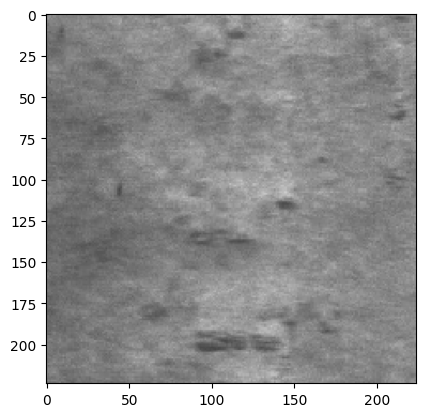

In [5]:
example_image = train_ds.next()[0][0]
print(example_image.shape)
plt.imshow(example_image[:,:])

As you can see above; the images you'll be working with are 3 things: 
1. Relatively small, only 224 x 224 pixels. 
2. In colour as they have 3 channels, but appear greyscale. 
3. Pretty boring to look at!

The image below shows a wider variety of the types of image which are available within the dataset. 

![steel photo examples](https://raw.githubusercontent.com/SeldonIO/deploy-workshops/master/manufacturing/assets/steel_images.jpeg "Title")

## Building the Models

Now that the data is loaded in and you have had the chance to explore and get to grips with it, you can turn your attention to model building. 

You will build and work on 2 separate models: 
1. Training from scratch a simple hand crafted architecture, using 3 convolutional layers. 
2. Fine tuning an InceptionV3 model which has been pre-trained on the ImageNet dataset. 

Once these models have been created you are going to deploy them alongside one another as a canary deployment via the Seldon Deploy SDK. 

Prior to beginning the building efforts create a simple callback which will stop training early if the validation accuracy breaks 90%. 

In [7]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.90 ):
            print("\nReached 90% validation accuracy so cancelling training!")
            self.model.stop_training = True 
            
callbacks = myCallback()

### Model 1: *Simple CNN*

Using Keras it is straightforward to define the CNN architecture, and this should be familiar if you have worked with CNNs before. 

Your neural network has three convolutional layers, each with 32 channels and a 3\*3 convolution. 

Looking at the model summary you can see the network has a total of approximately 11 million parameters. 

In [ ]:
simple_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)), # First Convolution
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), # Second Convolution
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), # Third Convolution
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax'),
])

simple_cnn.summary()

Training the network is then straightforward using standard methods; `categorical_crossentropy` for the loss function, and `adam` as the optimisation technique. 

In [ ]:
simple_cnn.compile(loss = 'categorical_crossentropy',
                   optimizer = 'adam',
                   metrics = ['accuracy'])

simple_cnn_history = simple_cnn.fit(train_ds,
                                    batch_size = 32,
                                    epochs = 3,
                                    validation_data = val_ds,
                                    callbacks = [callbacks],
                                    verbose = 1,
                                    shuffle=True)

Watching a neural network train is the modern equivalent of watching paint dry, therefore to speed things up feel free to interrupt training and grab the pre-trained example available below. 

In [ ]:
!mkdir simple-cnn/
simple_cnn.save('simple-cnn/')

In [ ]:

!gsutil cp -r simple-cnn/ gs://josh-seldon/workshops/manufacturing/pretrained/simple-cnn/1

In [6]:
simple_cnn = load_model("simple-cnn")

Now that you have a trained neural network you can grab a test image and have your network generate a prediction!

In [8]:
test_scratches = load_img('data/validation/images/scratches/scratches_241.jpg',
                          target_size=(224, 224, 3))

test_scratches = img_to_array(test_scratches)
test_scratches = test_scratches / 255
test_scratches  = test_scratches.reshape((-1,) + test_scratches.shape)

simple_preds = simple_cnn.predict(test_scratches)[0]
print(type(simple_preds))
for v, i in enumerate(simple_preds):
    print(f"{categories[v]}: {i:.2f}")

1/1 [==============================] - 0s 20ms/step
<class 'numpy.ndarray'>
crazing: 0.03
inclusion: 0.01
patches: 0.02
pitted_surface: 0.01
rolled-in_scale: 0.56
scratches: 0.37


As you can see the model is... **totally** wrong!

Even worse than that, it's confidently wrong- being fully convinced that the test scratch image has in fact been rolled in scale. 

The checkpointed model you're relying on here only acheived a validation accuracy of around 78% so this might be expected.

Let's see if this can be improved upon by using the InceptionV3 architecture.

### Model 2: *InceptionV3*

For your second model you will make use of the pre-trained InceptionV3 architecture. InceptionV3 is a CNN built for object classification by [researchers at Google in 2015](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf). Back then it held the state of the art crown for a while, however more recently has been overtaken by more modern EfficientNet or Transformer architectures. 

It has been selected here because it is reasonable to train on a CPU, it gets great results and Keras has a built-in version of the model making it super easy to get going with!

The key information to note around how you are preparing the InceptionV3 model is that when loaded you do not include the final layers (`include_top=False`). 

Three extra layers are then built on top of the InceptionV3 model; a pooling layer (`GlobalAveragePooling2D`), and two fully connected layers (`Dense`).

These new layers are glued onto InceptionV3 and compiled using the same evaluation methods as you used with the `simple-cnn`. 

In [ ]:
# parameters for architecture
input_shape = (224, 224, 3)
num_classes = 6
conv_size = 32

# parameters for training
batch_size = 32
num_epochs = 3

# load InceptionV3 from Keras
InceptionV3_model = InceptionV3(include_top=False, input_shape=input_shape)

# add custom Layers
x = InceptionV3_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
custom_output = Dense(num_classes, activation='softmax')(x)

# define the input and output of the model
inception = Model(inputs=InceptionV3_model.input, outputs=custom_output)
        
# compile the model
inception.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

inception.summary()

In [107]:
inception_history = inception.fit(train_ds,
                                  batch_size=32,
                                  epochs=1,
                                  validation_data=val_ds,
                                  callbacks=[callbacks],
                                  verbose=1, 
                                  shuffle=True)

 9/45 [=====>........................] - ETA: 1:43 - loss: 0.8446 - accuracy: 0.7222

: 

In [ ]:
# serving_signature.structured_outputs
type(serving_signature.inputs[0])

# loop through the layers of the model and print the name and shape
for layer in serving_signature.inputs:
    print(layer)
    

Watching an even larger neural network train is simply like watching an even larger wall dry, so once more you can take advantage of a pre-trained artefact.

In [106]:
serving_signature = inception.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]


AttributeError: 'Functional' object has no attribute 'signatures'

In [ ]:
!mkdir inception/
inception.save(inception, 'inception/')
!gsutil cp -r inception/ gs://josh-seldon/workshops/manufacturing/pretrained/inception/

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# parameters for architecture
input_shape = (224, 224, 3)
num_classes = 6
conv_size = 32

# parameters for training
batch_size = 32
num_epochs = 1

# load InceptionV3 from Keras
InceptionV3_model = InceptionV3(include_top=False, input_shape=input_shape)

# add custom Layers
x = InceptionV3_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
custom_output = Dense(num_classes, activation='softmax')(x)

# define the input and output of the model
inception = Model(inputs=InceptionV3_model.input, outputs=custom_output)

# compile the model
inception.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Save the model as a SavedModel
tf.saved_model.save(inception, "saved_model")

# Load the SavedModel
loaded_model = tf.saved_model.load("saved_model")

# Get the default serving signature
serving_signature = loaded_model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]

# Access signature inputs and outputs
input_tensor_info = serving_signature.inputs
output_tensor_info = serving_signature.outputs

# Example: Print input and output names and shapes
for input_name, input_info in input_tensor_info.items():
    print("Input name:", input_name)
    print("Input shape:", input_info.shape)

for output_name, output_info in output_tensor_info.items():
    print("Output name:", output_name)
    print("Output shape:", output_info.shape)


In [ ]:
docker run --rm -p8000:8000 -p8001:8001 -p8002:8002 -v simple-cnn:/models nvcr.io/nvidia/tritonserver:22.11-py3 tritonserver --model-repository=/models

In [23]:
import torch
from PIL import Image
from torchvision import transforms

client_preprocessor = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

In [42]:
from mlserver.codecs import NumpyCodec
from mlserver.types import InferenceRequest
import numpy as np
import json
from PIL import Image

input_image = Image.open("/Users/josh/Documents/seldon/deploy-workshops/manufacturing/data/train/images/crazing/crazing_5.jpg")

# example_image = train_ds.next()[0][0]
print(type(input_image))
# plt.imshow(input_image[:,:])

input_tensor = client_preprocessor(input_image)

input_batch = input_tensor.unsqueeze(0)
print(type(input_batch))
triton_ensemble_input = NumpyCodec.encode_input("input_1", np.array(input_batch))
print(type(triton_ensemble_input))
triton_ensemble_request = InferenceRequest(inputs = [triton_ensemble_input])
print(type(triton_ensemble_request.dict())) 

with open('triton_ensemble_request.json', 'w') as fp:
    json.dump(triton_ensemble_request.dict(), fp)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'torch.Tensor'>
<class 'mlserver.types.dataplane.RequestInput'>
<class 'dict'>


In [41]:
print(triton_ensemble_request.dict())

{'inputs': [{'name': 'input_1', 'shape': [1, 3, 224, 224], 'datatype': 'FP32', 'parameters': {'content_type': 'np'}, 'data': [0.772549033164978, 0.7843137383460999, 0.6627451181411743, 0.6509804129600525, 0.6196078658103943, 0.6078431606292725, 0.6666666865348816, 0.7058823704719543, 0.6901960968971252, 0.7058823704719543, 0.7372549176216125, 0.7215686440467834, 0.6784313917160034, 0.6941176652908325, 0.686274528503418, 0.6235294342041016, 0.6039215922355652, 0.6352941393852234, 0.6745098233222961, 0.7058823704719543, 0.7137255072593689, 0.7568627595901489, 0.7529411911964417, 0.7529411911964417, 0.7647058963775635, 0.6901960968971252, 0.7215686440467834, 0.7529411911964417, 0.772549033164978, 0.7960784435272217, 0.7764706015586853, 0.7568627595901489, 0.6980392336845398, 0.6274510025978088, 0.6705882549285889, 0.8274509906768799, 0.8666666746139526, 0.8509804010391235, 0.8549019694328308, 0.7490196228027344, 0.658823549747467, 0.6392157077789307, 0.6823529601097107, 0.7176470756530762

In [25]:
import requests

endpoint = "http://localhost:8000/v2/models/inception/infer"

response = requests.post(endpoint, json=triton_ensemble_request.dict())
print(json.dumps(response.json(), indent=2))

{
  "error": "[request id: <id_unknown>] unexpected shape for input 'input_1' for model 'inception'. Expected [-1,224,224,3], got [1,3,224,224]. NOTE: Setting a non-zero max_batch_size in the model config requires a batch dimension to be prepended to each input shape. If you want to specify the full shape including the batch dim in your input dims config, try setting max_batch_size to zero. See the model configuration docs for more info on max_batch_size."
}


In [ ]:
!mkdir inception/
!gsutil cp -r gs://josh-seldon/workshops/manufacturing/pretrained/inception/1 inception/

In [10]:
inception = load_model("model-repo/inception/1/model.savedmodel/")

Similarly to the `simple_cnn` built earlier you can test your `inception` model on the same `test_scratch` image to get an anecdotal feel for how it's going to perform. 

In [13]:
inception_preds = inception.predict(test_scratches)[0]
print(inception_preds.shape)
for v, i in enumerate(inception_preds):
    print(f"{categories[v]}: {i:.2f}")

1/1 [==============================] - 0s 81ms/step
(6,)
crazing: 0.00
inclusion: 0.00
patches: 1.00
pitted_surface: 0.00
rolled-in_scale: 0.00
scratches: 0.00


In [20]:
import numpy as np
from tritonclient.utils import np_to_triton_dtype
from google.protobuf.descriptor_pb2 import DataType
from tritonclient.grpc.model_config_pb2 import ModelInput, ModelOutput, ModelConfig


# Assuming 'output_array' is the NumPy array containing the output
output_shape = inception_preds.shape
output_dtype = np_to_triton_dtype(inception_preds.dtype)
output_dtype_enum = DataType.Value(output_dtype)

# Create Triton model configuration
model_config = ModelConfig()
model_config.name = "my_model"

# Define the model output
output_config = ModelOutput()
output_config.name = "output"
output_config.data_type = output_dtype_enum
output_config.dims.extend(output_shape)

# Set the model output in the model configuration
model_config.output.extend([output_config])

# Save the Triton model config to a file
with open("config.pbtxt", "w") as f:
    f.write(str(model_config))

ImportError: cannot import name 'DataType' from 'google.protobuf.descriptor_pb2' (/Users/josh/miniforge3/envs/deploy-advance/lib/python3.9/site-packages/google/protobuf/descriptor_pb2.py)

In [ ]:
docker run --rm -p 8000:8000 -p 8001:8001 -p 8002:8002 -v /Users/josh/Documents/seldon/deploy-workshops/manufacturing/model-repo/:/models --name tritonserver nvcr.io/nvidia/tritonserver:23.03-py3 tritonserver --model-repository=/models --strict-model-config=false

**Hurrah!** 

This result looks better, and you can also take some reassurance that this pre-trained `inception` model achieved a much more respectable validation accuracy of 94%. 

Time to start thinking about how you might want to serve your newly created models. 

## Deploying Your Models

Now that you have trained and saved your model artefacts you can begin to consider how to deploy them with Seldon. 

This process will involve uploading the relevant artefacts to blob storage, where they can be pulled from at deployment time. (As we will use the pretrained models rather than training in the workshop, the models are already in a google storage bucket, so we don't need to carry out the upload.)

You will then configure connection to a Seldon Deploy cluster, and leverage the pre-built Tensorflow Serving runtime to create your deployment. 

---

To begin with, you will push the `simple-cnn` and `inception` models to a Google storage bucket. It's worth noting that Seldon Deploy reads from a wide range of storage back ends and so all of the popular blob storage tools are covered as well. (As we will use the pretrained models rather than training in the workshop, the models are already in a google storage bucket, so we don't need to carry out the upload.).

You will create a unique folder with your name. Remember to replace `YOUR NAME` with your name.

Tensorflow Serving, similarly to Nvidia's Triton, when pulling model artefacts from a directory expects that there are sub-directories representing the version of the model artefacts. TF Serving can then be configured to serve a given model version. 

Given that you only have the single version for both of your models currently you will simply save version 1.

In [ ]:
# !gsutil cp -r simple-cnn/1/ gs://tom-seldon-examples/workshops/manufacturing/<YOUR NAME>/simple-cnn/
# !gsutil cp -r inception/1/ gs://tom-seldon-examples/workshops/manufacturing/<YOUR NAME>/inception/

## Creating Triton Config Files

In [102]:
%%writefile ./inception/config.pbtxt
platform: tensorflow_savedmodel
backend: "tensorflow"
name: inception
max_batch_size: 32
input [
    {
        name: "input_1"
        data_type: TYPE_FP32
        dims: [ 1, 224, 224, 3 ]
    }
]
output [
    {
        name: "dense_1/Softmax"
        data_type: TYPE_FP32
        dims: [ 1, 6 ]
    }
]


Overwriting ./inception/config.pbtxt


In [97]:
TRITON_IMAGE = 'nvcr.io/nvidia/tritonserver:23.03-py3'
import os
REPO_PATH = os.path.abspath('inception')
os.makedirs(REPO_PATH, exist_ok=True)

print(REPO_PATH)

/Users/josh/Documents/seldon/deploy-workshops/manufacturing/inception


In [101]:
!docker run -d -p 8000:8000 -p 8001:8001 -p 8002:8002 -v {REPO_PATH}/:/models --name tritonserver {TRITON_IMAGE} tritonserver --model-repository=/models

54cbdfa7e42bdb8d98b084d970f1b47e71b29f2f0f2e5f50da7e6d76184cb57f


In [ ]:
docker run --rm -p 8000:8000 -p 8001:8001 -p 8002:8002 -v /Users/josh/Documents/seldon/deploy-workshops/manufacturing/model-repo/:/models --name tritonserver nvcr.io/nvidia/tritonserver:23.03-py3 tritonserver --model-repository=/models

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tritonclient.utils import triton_to_np_dtype
from tritonclient.grpc.model_config_pb2 import ModelConfig
from google.protobuf import text_format

# # Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((-1, 28, 28, 1)).astype("float32") / 255.0
x_test = x_test.reshape((-1, 28, 28, 1)).astype("float32") / 255.0

# # Define the model architecture
# model = tf.keras.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(10, activation='softmax')
# ])

# # Compile and train the model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

# # Save the trained model
# model.save("trained_model")

# Create Triton model configuration
model_config = ModelConfig()
model_config.name = "mnist-model"
model_config.platform = "tensorflow"

# Set the version policy (optional)
# model_config.version_policy.max_versions = 1

# Iterate over the inputs in the model
input_config = model_config.input.add()
input_config.name = "input"
input_config.data_type = triton_to_np_dtype(x_train.dtype)
input_config.dims.extend(x_train[0].shape)

# Iterate over the outputs in the model
output_config = model_config.output.add()
output_config.name = "output"
output_config.data_type = triton_to_np_dtype(y_train.dtype)
output_config.dims.extend(y_train[0].shape)

# Save the Triton model config to a file
with open("config.pbtxt", "w") as f:
    f.write(text_format.MessageToString(model_config))


In [ ]:
create_config("./simple-cnn", "simple-cnn")

You can now deploy your models to the dedicated Seldon Deploy cluster which has been configured for this workshop. To do so you will interact with the Seldon Deploy SDK and deploy your model using that.

First, setting up the configuration and authentication required to access the cluster. Don't forget to update the `SD_IP` variable to your cluster IP.

In [ ]:
SD_IP = "35.243.251.120"
config = Configuration()
config.host = f"https://{SD_IP}/seldon-deploy/api/v1alpha1"
config.oidc_client_id = "sd-api"
config.oidc_server = f"https://{SD_IP}/auth/realms/deploy-realm"
config.oidc_client_secret = "sd-api-secret"
config.auth_method = "client_credentials"
config.verify_ssl = False

def auth():
    auth = OIDCAuthenticator(config)
    config.id_token = auth.authenticate()
    api_client = ApiClient(configuration=config, authenticator=auth)
    return api_client

Now you have configured the IP correctly as well as setup the authentication function you can describe the deployment you would like to create. 

As you have uncovered earlier the `simple-cnn` is not great, and the `inception` model improves dramatically on that performance. This has been demonstrated on your validation data, but neither model has seen any live data. 

In this scenario you may wish to test both models on the live data, to achieve this Seldon Deploy provides you with two options; a shadow deployment or a canary deployment. 

These techniques are usually applied to the rollout or upgrade of a new model version. A shadow deployment deploys two models behind a single endpoint, both of the models receive 100% of the traffic- there is no split. However, only one of the models' responses are returned to users- usually the original model you are upgrading. The others responses (new version) are simply logged to Elasticsearch where you can see how it responded compared to the original model. This allows you to roll out new versions of a model and test them on live data, without the risk of poor performance impacting user experience. 

The other option is a canary deployment; this involves a traffic split between the two models behind a single endpoint. The percentage split is determined by you, and allows you to control how much of the live data goes to each of the models. New versions of models will typically be sent a smaller percentage of traffic (10% or 20%) to validate they are behaving as expected before they are rolled out more fully.

In this example you will create a canary deployment with a 70/30 split between the `inception` model and `simple-cnn` respectively. 

---

The [Seldon Deploy SDK](https://github.com/SeldonIO/seldon-deploy-sdk) offers two approaches to creating deployments: 
1. Working directly with dictionaries, which are equivalent to the underlying Kubernetes manifests. 
2. Using the higher level Python classes as abstractions. 

In this example you will use the more direct approach of working with the dictionaries. While this requires some more configuration it does create the opportunity to make reusable templates which are custom to your needs and can be readily shared and understood by others. 

You will start by defining some variables for the deployment which will be passed to the `mldeployment` manifest object in the following cell. 

In [ ]:
YOUR_NAME = "jman"
DEPLOYMENT_NAME = f"{YOUR_NAME}-manufacturing"
NAMESPACE = "seldon-gitops"

MODEL_NAME = "inception"
MODEL_LOCATION = f"gs://josh-seldon/workshops/manufacturing/pretrained/simple-cnn/"

CANARY_NAME = "simple-cnn"
CANARY_LOCATION = f"gs://josh-seldon/workshops/manufacturing/pretrained/inception/"

CPU_REQUESTS = "1"
MEMORY_REQUESTS = "1Gi"

CPU_LIMITS = "1"
MEMORY_LIMITS = "1Gi"

In [ ]:
mldeployment = {
    "kind": "SeldonDeployment",
    "metadata": {
        "name": DEPLOYMENT_NAME,
        "namespace": NAMESPACE
    },
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "spec": {
        "name": DEPLOYMENT_NAME,
        "protocol": "seldon",
        "predictors": [
            {
                "componentSpecs": [
                    {
                        "spec": {
                            "containers": [
                                {
                                    "name": f"{CANARY_NAME}",
                                    "resources": {
                                        "requests": {
                                            "cpu": CPU_REQUESTS,
                                            "memory": MEMORY_REQUESTS
                                        },
                                        "limits": {
                                            "cpu": CPU_LIMITS,
                                            "memory": MEMORY_LIMITS
                                        }
                                    }
                                }
                            ]
                        }
                    }
                ],
                "name": "default",
                "replicas": 1,
                "traffic": 100,
                "graph": {
                    "implementation": "TENSORFLOW_SERVER",
                    "modelUri": CANARY_LOCATION,
                    "name": f"{CANARY_NAME}",
                    "logger": {
                        "mode": "all"
                    }
                }
            }
             ]
    }
}

Once you have specified your `mldeployment` JSON it is a simple API call to create your deployment. 

In [ ]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

You can now test your model endpoint in the UI. To access the workshop cluster use the following details: 

Don't forget to replace XXXXX in the below URL with your cluster IP.

* Seldon Deploy URL: http://XXXXX/seldon-deploy/
* Username: admin@seldon.io
* Password: 12341234

Once you have seen your deployment creating you can save a sample image using the `test-scratches` array you worked with earlier. 

This `test-scratches.json` can be uploaded directly to the UI to test your model endpoint when it is available!

In [ ]:
seldon_sample = {
  "data": {
    "names": [
    ],
    "ndarray": test_scratches.tolist()
  }
}

with open('test-scratches.json', 'w', encoding='utf-8') as f:
    json.dump(seldon_sample, f, ensure_ascii=False, indent=1)

## Deploying Core V2

In [ ]:
risk_model = {
   "kind":"Model",
   "metadata":{
      "name":f"{CANARY_NAME}",
      "namespace":"seldon-gitops",
      "annotations":{
         "seldon.io/project":"default"
      }
   },
   "spec":{
      "storageUri":CANARY_LOCATION,
      "requirements":[
         "tensorflow"
      ],
      "replicas":1,
      "memory":"1000Ki"
   }
}

risk_model
model_client = ModelsApi(auth())
try:
    api_response = model_client.create_model(NAMESPACE, risk_model, async_req=False)
    print(api_response)
except ApiException as e:
    print("Exception when calling ModelsApi->create_model: %s\n" % e)

In [ ]:
!kubectl get models -n seldon-gitops

In [ ]:
try:
    api_response = model_client.delete_model(CANARY_NAME, NAMESPACE)
    print(api_response)
except ApiException as e:
    print("Exception when calling ModelsApi->delete_model: %s\n" % e)

## Adding Model Metadata

You have now created 2 new models within a single deployment. Both of these models have been automatically added to the model catalog. The model catalog acts as a centralised repository for metadata associated with models. Models can be easily deployed directly from the catalog, while metadata acts to speed knowledge transfer between teams and to track models across tools.

You will now add some metadata to your InceptionV3 model describing the validation accuracy you managed to achieve, and who authored the model- so you can brag to your colleagues!

In [ ]:
model_catalog_metadata = {
      "URI": CANARY_LOCATION,
      "name": "InceptionV3",
      "version": "v1.0",
      "artifactType": "TENSORFLOW",
      "taskType": "defect classification",
      "tags": {
        "auto_created": "true",
        "author": f"{YOUR_NAME}"
      },
      "metrics": {},
      "creationTime": "2022-02-15T15:26:26.630592Z",
      "project": "default"
    }

In [ ]:
api_instance = ModelMetadataServiceApi(auth())
api_response = api_instance.model_metadata_service_update_model_metadata(model_catalog_metadata)

Listing the metadata for your newly updated model:

In [ ]:
api_response = api_instance.model_metadata_service_list_model_metadata(uri=MODEL_LOCATION)
api_response

# Drift Detection

The final stage of the deployment process is going to be adding the advanced monitoring capabilities afforded by a drift detector. 

In this example you will use Alibi Detect to train a custom drift detector which can flag when the underlying input data distribution has shifted. This can inform decisions about re-training or prompt deeper investigation into data/model behaviours. 

Seldon Deploy also allows you to setup alerts when drift is detected. 

---

In this example you will use the Maximum Mean Discrepancy method. Covariate or input drift detection relies on creating a distance measure between two distributions; a reference distribution and a new distribution. The MMD drift detector is no different; the mean embeddings of your features are used to generate the distributions and then the distance between them is measured. The training data is used to calculate the reference distribution, while the new distribution comes from your inference data.  

More technically, a reproducing kernel Hilbert space is used to generate the mean embeddings, by mapping the highly complex feature space within which most machine learning models operate to a linear Euclidean space. A radial basis function kernel is then used to measure the distance between the two embeddings, and the signifiance of the drift is calculated as a p-value using permutation/resampling tests. More details can be found [here](https://docs.seldon.io/projects/alibi-detect/en/v0.10.3/cd/methods/mmddrift.html).

Before you dive into creating your own drift detector, you need to generate a reference dataset. In this case you use 5 batches of the training data set, resulting in 160 images. This has been picked for convenience and speed of training in the workshop, and if this was a production case you would likely want to use the entirety of the training set, or a statistically significant segment.

Now, creating your reference set. 

In [ ]:
train_ds.reset()

drift_ref = train_ds.next()[0]

for i in range(4):
    drift_ref = np.concatenate((drift_ref, train_ds.next()[0]))

drift_ref.shape

Due to the high dimensionality of image data you will need perform a pre-processing step to make it computationally feasible to detect drift on incoming batches of images. 

A great option for this is to use an simple encoding neural network. This will squish images from their original shape of `(224, 224, 3)` to a vector of `32`. From there we can feed the vectors to the drift detector and calculate drift values. 

This is then used to a generate a `preprocess_fn` which will be fed to your MMD drift detector to convert your images ahead of time. 

In [ ]:
# define encoder
encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(224, 224, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)

# define preprocessing function
preprocess_fn = partial(preprocess_drift, model=encoder_net, batch_size=160)

Next you can initialise the drift detector; this is as simple as a single line API call specifying the:
* Reference data
* Computational backend
* The p-value below which drift is considered to have occurred
* Your preprocessing function
* The number of permutations taken to calculate the p-value

In [ ]:
# initialise drift detector
cd = MMDDrift(drift_ref, backend='tensorflow', p_val=.05, preprocess_fn=preprocess_fn, n_permutations=100)

Once your shiny new drift detector has trained you can test it on a new batch of data!

In [ ]:
new_batch = train_ds.next()[0]
preds = cd.predict(new_batch, return_p_val=True, return_distance=True)
preds

Finally, you can save the drift detector and upload it to Google storage for deployment. 

In [ ]:
filepath = 'defect-drift'
save_detector(cd, filepath)

In [ ]:
!gsutil cp -r defect-drift gs://tom-seldon-examples/workshops/manufacturing/{YOUR_NAME}/defect-drift

To deploy the drift detector you will use Seldon Deploy's user interface. Simply navigate to your deployment, and select the "Create" button for your drift detector.

This will bring up a form. Add your `Detector Name`, the `Storage URI`:


In [ ]:
print(f"gs://tom-seldon-examples/workshops/manufacturing/{YOUR_NAME}/defect-drift")

the `Batch Size`:

20

and the `Drift Type`:

Batch

The batch size configuration sets how many data points have to be sent to the endpoint before drift is calculated.

In order to test your drift detector, you can run the same image through your deployed model 20 times. You can see both in the drift detector logs and in the Drift Detection screen within the monitoring tab, that drift has occurred. 